In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
CONTEXT_SIZE = 2 #Window size을 뜻함

text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()
#띄어쓰기 기준으로 split

print(text)
vocab = set(text) #text는 배열안에 존재 vocab 나눠준거 {'We','are',.. } 이런식으로 
#set 함수는 dictionary 와 비슷하지만, key가 없고 값만 존재한다.
vocab_size = len(vocab)
print(vocab)
print('vocab_size:', vocab_size)

#단어 사전 만듦 key, value 바꿔가면서
w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

['We', 'are', 'about', 'to', 'study', 'the', 'idea', 'of', 'a', 'computational', 'process.', 'Computational', 'processes', 'are', 'abstract', 'beings', 'that', 'inhabit', 'computers.', 'As', 'they', 'evolve,', 'processes', 'manipulate', 'other', 'abstract', 'things', 'called', 'data.', 'The', 'evolution', 'of', 'a', 'process', 'is', 'directed', 'by', 'a', 'pattern', 'of', 'rules', 'called', 'a', 'program.', 'People', 'create', 'programs', 'to', 'direct', 'processes.', 'In', 'effect,', 'we', 'conjure', 'the', 'spirits', 'of', 'the', 'computer', 'with', 'our', 'spells.']
{'idea', 'effect,', 'spirits', 'In', 'are', 'manipulate', 'The', 'As', 'data.', 'Computational', 'with', 'People', 'about', 'direct', 'computer', 'the', 'process', 'abstract', 'a', 'our', 'We', 'they', 'directed', 'programs', 'that', 'study', 'to', 'process.', 'inhabit', 'program.', 'processes.', 'things', 'beings', 'of', 'computational', 'evolution', 'processes', 'is', 'rules', 'spells.', 'by', 'we', 'computers.', 'othe

## Token생성했으므로 -> (Make Corpus: Numbering(Dictionary))
## => 단어 임베딩 필요 <word2Vec 사용>

### 단어 임베딩을 위한 trainset 전처리 과정
- Negative Sampling 이란 Softmax 함수를 전체 trainset에 말고 window 밖의 일부 trainset에만 적용

In [3]:
##train을 위한 데이터셋을 만들어줌

##Word2Vec중 CBOW 쓸때
def create_cbow_dataset(text):
    data = []
    for i in range(2, len(text) - 2): #context size을 설정해준대로 2빼기
        context = [text[i - 2], text[i - 1],
                   text[i + 1], text[i + 2]] #context word 중심단어 옆에 주변단어들 list
        target = text[i] #중심단어임
        data.append((context, target)) #data라는 list 에 (주변단어, 중심단어) 로 설정
    return data

##Word2Vec중 skipgram 쓸때 + Negative Sampling을 위한 data set도 만들어주기
def create_skipgram_dataset(text):
    import random
    data = [] 
    for i in range(2, len(text) - 2):
        data.append((text[i], text[i-2], 1))
        data.append((text[i], text[i-1], 1))
        data.append((text[i], text[i+1], 1))
        data.append((text[i], text[i+2], 1))
        #data라는 list에 (중심단어, 주변단어) 설정
        ##negative Sampling 하는 방법// random으로 id 부여
        #random id에 대한 텍스트는 관계가 없다라는 값을 넣어줌
        for _ in range(4):
            if random.random() < 0.5 or i >= len(text) - 3:
                rand_id = random.randint(0, i-1)
            else:
                rand_id = random.randint(i+3, len(text)-1)
            data.append((text[i], text[rand_id], 0)) 
            #random으로 뽑힌 아이디 값도 (중심단어, negative 주변단어) 설정.
            #대신 weight는 관계가 없으니, 0으로 넣어줌. weight 업데이트 해줄 필요성 없음 (해주기엔 너무 많은 양의 계산이 필요함)
    return data

cbow_train = create_cbow_dataset(text)
skipgram_train = create_skipgram_dataset(text)
print('cbow sample', cbow_train[0]) 
print('skipgram sample', skipgram_train[0]) 
print('skipgram sample', skipgram_train[4]) #random으로 negative Sampling 한거

cbow sample (['We', 'are', 'to', 'study'], 'about')
skipgram sample ('about', 'We', 1)
skipgram sample ('about', 'We', 0)


## CBOW&SKIPGRAM 단일 신경망 제작

In [4]:
##학습 전 학습을 위한 단일 신경망 제작.
#CBOW 형태의 단일 신경망 제작
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__() #super 상속 개념 : 자식 클래스에서 부모 클래스를 사용하고 싶을 경우 

        self.embeddings = nn.Embedding(vocab_size, embd_size) #임베딩 벡터를 얻기 위한 임베딩layer
        #nn.Embeddding(num_embeddings=len(vocab),embedding_dim=3,pedding_idx=1) #dim 벡터의 차원(사용자가 지정해줌)
        #차원을 맞춰주기 위함 (embd_size로)
        
        #nn.Linear(input_dim, output_dim)        
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size) #inputlayer
        #context_size=window size, 한단어 마다 embd_size만큼, * data set 은 (context, target)으로 구성 즉, *2 해주기
        self.linear2 = nn.Linear(hidden_size, vocab_size) 
        #Output layer. CBOW는 vocab_size 만큼 나와야함.
        #size를 맞춰주기 위해서 vocab_size로 output를 둠
        
    def forward(self, inputs):
        ##embedded(벡터화)->layer1->Relu->hid->layer2->softmax()->log_probs
        embedded = self.embeddings(inputs).view((1, -1)) 
        hid = F.relu(self.linear1(embedded))
        #embedded를 넣고 relu를 돌린후 hid에 넣기
        out = self.linear2(hid) 
        #레이어2를 hid를 넣어서 out 나오게
        log_probs = F.log_softmax(out) #softmax 사용
        return log_probs #CBOW output 값
    
    
#SkipGram 형태의 단일 신경망 제작
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size) 
        #embedding벡터만 필요
        #둘의 곱으로 표현된 embedding matrix
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))  
        # .view:1차원으로 만들어줌 차원 reshape 해주기(1,-1) #단, -1 을 다른 차원에 맞춰서 자동으로 차원 설정
        
        embed_ctx = self.embeddings(context).view((1, -1)) #focus 와 context 로 쭉쭉 펴줌
        score = torch.mm(embed_focus, torch.t(embed_ctx)) #torch.mm : 내적을한다는 뜻
        
        #행렬곱을 진행. 높을수록 관련있다
        log_probs = F.logsigmoid(score) #시그모이드 진행
    
        return log_probs

## CBOW 와 SKIPGRAM 학습 진행

In [5]:
embd_size = 100 #각 단어 별로 100차원으로 설정
learning_rate = 0.001 
n_epoch = 30 #전체 데이터를 몇번 훑을지


# CBOW(
#   (embeddings): Embedding(49, 100)
#   (linear1): Linear(in_features=400, out_features=64, bias=True)
#   (linear2): Linear(in_features=64, out_features=49, bias=True)
# )


def train_cbow():
    hidden_size = 64 
    losses = [] #loss값을 계산하고 그 값을 list에 입력
    loss_fn = nn.NLLLoss() #loss function
    model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size) #CBOW 클래스
    optimizer = optim.SGD(model.parameters(), lr=learning_rate) #pytorch 에서 weight 갱신해주는 패키지
    # optim 패키지를 사용하여 모델의 가중치를 갱신할 Optimizer를 정의합니다.
    # optim 패키지도 종류가 많다. 이중 우린 SGD (GradientDescent) 사용. (그외, RMS, Adam등)


    for epoch in range(n_epoch): #epoch 만큼
        total_loss = .0 #전체적인 loss 값은 0
        
        for context, target in cbow_train: #context, target 돌아가기
            ctx_idxs = [w2i[w] for w in context] #context만으로 index 설정
            ctx_var = Variable(torch.LongTensor(ctx_idxs)) #Variable 로 index들을 벡터화 시켜줌 
            #torch.LongTensor -> 데이터 타입임 자료형변환
            
            model.zero_grad() #model의 weight을 0으로 초기화
            log_probs = model(ctx_var)#벡터화시킨걸 model에 돌리기 
            #예상값이 나옴
            
            loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))
            #타겟값과 probality 계산
            
            loss.backward()
            optimizer.step() #weight 업데이트
            total_loss += loss.data #loss 리스트에 업데이트
        losses.append(total_loss)
    return model, losses

def train_skipgram():
    losses = [] 
    loss_fn = nn.MSELoss() #loss 는 MSE로 넣어봄 
    model = SkipGram(vocab_size, embd_size) #CBOW 와 다르게 두개만 받게 설정
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate) #SGD로 OPtimizer 설정
    
    for epoch in range(n_epoch):
        total_loss = .0
        for in_w, out_w, target in skipgram_train:
            in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
            out_w_var = Variable(torch.LongTensor([w2i[out_w]])) 
            
            model.zero_grad()
            log_probs = model(in_w_var, out_w_var)
            loss = loss_fn(log_probs[0], Variable(torch.Tensor([target])))
            #loss계산
            
            loss.backward()
            optimizer.step()
            #loss계산한거 backpropagation 하고 optimizer를 통해 weight 갱신
            
            total_loss += loss.data
        losses.append(total_loss)
    return model, losses

train_skipgram()

SkipGram(
  (embeddings): Embedding(49, 100)
)


(SkipGram(
   (embeddings): Embedding(49, 100)
 ),
 [tensor(16796.6875),
  tensor(3396.6379),
  tensor(1258.6238),
  tensor(686.8545),
  tensor(481.5197),
  tensor(393.8079),
  tensor(349.8574),
  tensor(324.4760),
  tensor(308.1470),
  tensor(296.7898),
  tensor(288.4325),
  tensor(282.0202),
  tensor(276.9409),
  tensor(272.8154),
  tensor(269.3961),
  tensor(266.5149),
  tensor(264.0533),
  tensor(261.9250),
  tensor(260.0661),
  tensor(258.4284),
  tensor(256.9742),
  tensor(255.6741),
  tensor(254.5048),
  tensor(253.4474),
  tensor(252.4862),
  tensor(251.6086),
  tensor(250.8044),
  tensor(250.0644),
  tensor(249.3813),
  tensor(248.7488)])

In [6]:
cbow_model, cbow_losses = train_cbow()
sg_model, sg_losses = train_skipgram()

C:\Users\woojung\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


SkipGram(
  (embeddings): Embedding(49, 100)
)


## Testset model

In [7]:
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx] #index 값을 뽑아냄
        ctx_var = Variable(torch.LongTensor(ctx_idxs)) #variable 뽑아냄

        model.zero_grad()
        log_probs = model(ctx_var)
        
        ##MAX 맞추기 위함
        _, predicted = torch.max(log_probs.data, 1) #log_prob에서 max로 뽑아냄
        ##제일 높은 값의 item 맞추기
        predicted_word = i2w[predicted.item()]  #제일 높은 값을 item으로
        print('predicted:', predicted_word)
        print('label    :', target)
        if predicted_word == target: # taget이랑 predict 한거랑 같았으면 값은 1, 다르면 0
            correct_ct += 1 
    #0과 1의 값으로 Accuracy 계산       
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

def test_skipgram(test_data, model):
    print('====Test SkipGram===')
    correct_ct = 0
    for in_w, out_w, target in test_data:#두 in out 관련 있으면 1, 없으면 0
        in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
        out_w_var = Variable(torch.LongTensor([w2i[out_w]]))

        model.zero_grad() 
        
        log_probs = model(in_w_var, out_w_var)
        
        _, predicted = torch.max(log_probs.data, 1) #가장 높은 값 predicted
        predicted = predicted[0]
        if predicted == target: #taget이랑 맞다면 1 틀리면 0
            correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [8]:
test_cbow(cbow_train, cbow_model)
print('------')
test_skipgram(skipgram_train, sg_model)

====Test CBOW===
predicted: about
label    : about
predicted: to
label    : to
predicted: study
label    : study
predicted: the
label    : the
predicted: idea
label    : idea
predicted: of
label    : of
predicted: a
label    : a
predicted: computational
label    : computational
predicted: process.
label    : process.
predicted: Computational
label    : Computational
predicted: processes
label    : processes
predicted: are
label    : are
predicted: abstract
label    : abstract
predicted: beings
label    : beings
predicted: that
label    : that
predicted: inhabit
label    : inhabit
predicted: computers.
label    : computers.
predicted: As
label    : As
predicted: they
label    : they
predicted: evolve,
label    : evolve,
predicted: processes
label    : processes
predicted: manipulate
label    : manipulate
predicted: other
label    : other
predicted: abstract
label    : abstract
predicted: things
label    : things
predicted: called
label    : called
predicted: a
label    : data.
predicted

C:\Users\woojung\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


of
predicted: a
label    : a
predicted: process
label    : process
predicted: is
label    : is
predicted: directed
label    : directed
predicted: by
label    : by
predicted: a
label    : a
predicted: pattern
label    : pattern
predicted: of
label    : of
predicted: a
label    : rules
predicted: called
label    : called
predicted: a
label    : a
predicted: program.
label    : program.
predicted: People
label    : People
predicted: create
label    : create
predicted: programs
label    : programs
predicted: to
label    : to
predicted: direct
label    : direct
predicted: the
label    : processes.
predicted: a
label    : In
predicted: effect,
label    : effect,
predicted: we
label    : we
predicted: conjure
label    : conjure
predicted: the
label    : the
predicted: spirits
label    : spirits
predicted: of
label    : of
predicted: the
label    : the
predicted: computer
label    : computer
predicted: with
label    : with
Accuracy: 93.1% (54/58)
------
====Test SkipGram===
Accuracy: 50.0% (23


Bad key "text.kerning_factor" on line 4 in
C:\Users\woojung\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


<Figure size 432x288 with 0 Axes>

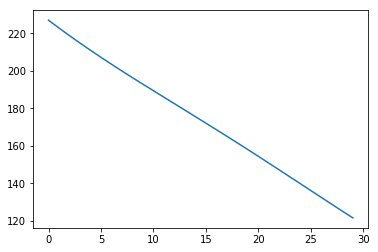

<Figure size 432x288 with 0 Axes>

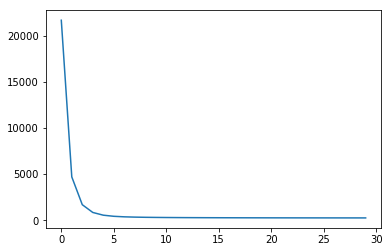

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(cbow_losses, 'CBOW Losses')
showPlot(sg_losses, 'SkipGram Losses')

### torchtext을 사용해서 GloVe 사용

In [10]:
#거대한 corpus을 통해서 학습을 완료시킨 vector들
import torch
import torchtext.vocab as vocab #GloVe 외 많음

glove = vocab.GloVe(name = "6B", dim = 100)
print("Loaded {} words".format(len(glove.itos))) #itos (index to string) 

Loaded 400000 words


In [11]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]
#get_word("name")

In [12]:
def closest(vec, n = 10):
    all_dists = [(w, torch.dist(vec, get_word(w))) for w in glove.itos]
    return sorted(all_dists, key = lambda t: t[1])[:n]

In [13]:
def print_tuples(tuples):
    for tuple in tuples:
        print("(%.4f) %s" % (tuple[1], tuple[0]))

In [14]:
print_tuples(closest(get_word("google")))

(0.0000) google
(3.0772) yahoo
(3.8836) microsoft
(4.1048) web
(4.1082) aol
(4.1165) facebook
(4.3917) ebay
(4.4122) msn
(4.4540) internet
(4.4651) netscape


In [15]:
def analogy(w1, w2, w3, n=5, filter_given=True):
    print('\n[%s : %s :: %s : ?]' % (w1, w2, w3))
    closest_words = closest(get_word(w2) - get_word(w1) + get_word(w3))    
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
        
    print_tuples(closest_words[:n])

In [16]:
analogy("king", "man", "queen")
#GloVe를 통해 가장 가까운 거리의 제일 나올 수 있는 확률이 높은 다섯개의 단어 나옴


[king : man :: queen : ?]
(4.0811) woman
(4.6916) girl
(5.2703) she
(5.2788) teenager
(5.3084) boy


In [17]:
analogy('man', 'actor', 'woman')
analogy('cat', 'kitten', 'dog')
analogy('dog', 'puppy', 'cat')
analogy('russia', 'moscow', 'france')
analogy('obama', 'president', 'trump')
analogy('rich', 'mansion', 'poor')
analogy('elvis', 'rock', 'eminem')
analogy('paper', 'newspaper', 'screen')
analogy('monet', 'paint', 'michelangelo')
analogy('beer', 'barley', 'wine')
analogy('earth', 'moon', 'sun')
analogy('house', 'roof', 'castle')
analogy('building', 'architect', 'software')
analogy('boston', 'bruins', 'phoenix')
analogy('good', 'heaven', 'bad')
analogy('jordan', 'basketball', 'woods')


[man : actor :: woman : ?]
(2.8133) actress
(5.0039) comedian
(5.1399) actresses
(5.2773) starred
(5.3085) screenwriter

[cat : kitten :: dog : ?]
(3.8146) puppy
(4.2944) rottweiler
(4.5888) puppies
(4.6086) pooch
(4.6520) pug

[dog : puppy :: cat : ?]
(3.8146) kitten
(4.0255) puppies
(4.1575) kittens
(4.1882) pterodactyl
(4.1945) scaredy

[russia : moscow :: france : ?]
(3.2697) paris
(4.6857) french
(4.7085) lyon
(4.9087) strasbourg
(5.0362) marseille

[obama : president :: trump : ?]
(6.4302) executive
(6.5149) founder
(6.6997) ceo
(6.7524) hilton
(6.7729) walt

[rich : mansion :: poor : ?]
(5.8262) residence
(5.9444) riverside
(6.0283) hillside
(6.0328) abandoned
(6.0681) bungalow

[elvis : rock :: eminem : ?]
(5.6597) rap
(6.2057) rappers
(6.2161) rapper
(6.2444) punk
(6.2690) hop

[paper : newspaper :: screen : ?]
(4.7810) tv
(5.1049) television
(5.3818) cinema
(5.5524) feature
(5.5646) shows

[monet : paint :: michelangelo : ?]
(6.0782) plaster
(6.3768) mold
(6.3922) tile
(6.58